# **Лабораторная работа 2**
*Naumov Anton (Any0019)*

*To contact me in telegram: @any0019*

В данном задании вашей задачей будет построить и обучить модель CycleGAN для задачи Img2Img.

---

Про задачу __Img2Img__:

- У вас есть 2 множества изображений ($A$ и $B$)
- Ваша задача - научиться превращать изображения из множества $A$ в изображения из множества $B$ и наоборот
- Бывают paired и unpaired множества
- В случае __paired__ множеств - для каждого изображения из $A$ существует конкретное изображение из $B$, в которое оно должно перейти (и наоборот). Примером такой пары множеств может быть (а) спутниковая фотграфия местности vs схематическая карта местности , (б) фотография фасада здания vs схема фасада здания , ...
- В случае __unpaired__ множеств - между множествами нет конкретных пар. Примером такой пары множеств может быть (а) фотографии с лошадьми vs фотографии с зебрами , (б) фотографии vs рисунки конкретного художника , ...

---

Про модель __CycleGAN__:

- Модель придумана для задачи Img2Img (в первую очередь unpaired версии) и основана на концепции GAN-ов
- В модели есть 2 генератора: $G_{A -> B}$ (задача которого - принимая на вход изображение из множества $A$ переводить его в изображение из множества $B$) и $G_{B -> A}$ (аналогично в другую сторону)
- Надо отметить что на вход генераторы не получают никакую дополнительную случайность, что делает обучение таких моделей проще
- В модели так же есть 2 дискриминатора: $D_{A}$ (задача которого - отличать реальные изображения из $A$ от сгенерированных с помощью $G_{B -> A}$ изображений) и $D_{B}$ (аналогично для $B$)
- Функцией ошибки будет, как и для GAN-ов, minmax игра между генераторами и дискриминаторами, но к ошибке генераторов добавится ещё и, так называемый, `cycle consistency loss`, который проверяет, что после двойного перехода изображения не меняются $G_{B -> A} \big( G_{A -> B} ( a ) \big) = a ; \forall a \in A$ и $G_{A -> B} \big( G_{B -> A} ( b ) \big) = b ; \forall b \in B$
- Так же можно добавлять или нет штраф за то, чтобы $G_{B -> A}$ не меняла изображения из $A$ и наоборот $G_{A -> B}$ не меняла изображения из $B$
- Оригинальная статья: https://arxiv.org/pdf/1703.10593.pdf

---

Ваша задача - ноутбук разбит на несколько частей, каждая со своими баллами

1. __Подготовка данных__ _(2 балла)_ --> требуется выбрать датасет для обучения (дано несколько на выбор) и составить пайплайн подготовки данных
2. __Составление модели__ _(6 баллов)_ --> требуется собрать нейросеть _(3 балла)_ и создать функции ошибки _(3 балла)_
3. __Подготовка обучения__ _(2 балла)_ --> требуется написать шаги обучения и валидации, визуализацию, а так же полный цикл обучения
4. __Обучение__ _(2 балла)_ --> требуется обучить модель
5. __Сбор своего датасета и обучение модели на нём__ _(3 балла)_ --> требуется собрать свой датасет и обучить на нём модель

***За наиболее интересные и качественные решения в пункте 5 так же предусмотрены дополнительные баллы***

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms as tr

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Для тёмной темы jupyter - уберите если не нужно
plt.style.use('dark_background')

from tqdm.auto import tqdm, trange

import os
import sys
import requests
import cv2

from dataclasses import dataclass

# 1. Подготовка данных (___2 балла___)

## 1.1 Выбор и скачивание датасета

In [ ]:
dataset_folder = "/content/img2img"
num_images_per_split = 5

os.environ["dataset_folder"] = dataset_folder
!mkdir -p $dataset_folder

# В этом цикле каждый из предложенных датасетов
#  - скачивается
#  - распаковывается
#  - отрисовывается + meta
#  - удаляется

# Предлагается посмотреть на все предложенные варианты датасетов и затем оставить один,
#  с которым захочется работать больше всего - закомментируйте (или удалите) все, кроме
#  выбранного, а так же закомментируйте строчки с удалением скачанного датасета
for dataset_name in [
    # Unpaired
    #"apple2orange",
    #"summer2winter_yosemite",
    "horse2zebra",
    #"monet2photo",
    #"cezanne2photo",
    #"ukiyoe2photo",
    #"vangogh2photo",
    # Paired
    #"maps",
    #"facades",
]:
    print(f"Dataset '{dataset_name}'")
    url = f"http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/{dataset_name}.zip"
    download_path = os.path.join(dataset_folder, f"{dataset_name}.zip")
    target_folder = os.path.join(dataset_folder, dataset_name)

    # Чтобы bash вызовы знали соответствующие переменные
    os.environ["url"] = url
    os.environ["download_path"] = download_path
    os.environ["target_folder"] = target_folder

    print("Loading zip file...", end="")
    # Проверяем что нет такого загруженого файла
    if not os.path.isfile(download_path) or os.path.exists(target_folder):
        # # Можно загрузить через requests библиотеку
        #response = requests.get(url)
        #open(download_path, "wb").write(response.content)

        # Можно загрузить через wget
        !wget $url -O $download_path
    print(" --> done!")

    print("Unziping...", end="")
    # Распаковываем
    if os.path.exists(target_folder):
        !rm -r $target_folder
    #!mkdir -p ${dataset_folder}

    zippath = target_folder + ".zip"
    print('\n', zippath)
    !unzip $zippath -d $dataset_folder
    #!unzip $zippath
    print(" --> done!")

    # Удаляем zip-файл
    #!rm -r ${download_path}

    # Meta + Отрисовка
    print(f"Provided splits: {os.listdir(target_folder)}")
    # Удобный способ быстро получить датасет картинок с лэйблами, если картинки разложены по папкам в формате:
    # root_folder/label_name/img.jpg
    # (в нашем случае нет лэйблов, но картинки разложены в таком же формате, просто вместо label_name идёт
    #  split_name: trainA/testA/trainB/testB)
    dataset = datasets.ImageFolder(target_folder)

    inds_to_show = {i: [] for i, _ in enumerate(dataset.classes)}
    classes_full = 0
    for dataset_ind in range(len(dataset)):
        _, split_ind = dataset[dataset_ind]
        if len(inds_to_show[split_ind]) == num_images_per_split:
            continue
        inds_to_show[split_ind].append(dataset_ind)
        if len(inds_to_show[split_ind]) == num_images_per_split:
            classes_full += 1
        if classes_full == len(dataset.classes):
            break

    for split_name in sorted(dataset.classes):
        split_ind = dataset.class_to_idx[split_name]
        print(f"Split '{split_name}' of dataset '{dataset_name}'", end="")
        split_folder = os.path.join(target_folder, split_name)
        print(f" --> size: {len(os.listdir(split_folder))}")

        plt.subplots(1, num_images_per_split, figsize=(5 * num_images_per_split, 5))
        plt.suptitle(f"{dataset_name} ~ {split_name}", y=0.95)
        for i, dataset_ind in enumerate(inds_to_show[split_ind]):
            plt.subplot(1, num_images_per_split, i + 1)
            plt.imshow(dataset[dataset_ind][0])
            plt.xticks([])
            plt.yticks([])
        plt.show()

    # Удаляем скачанный датасет
    #!rm -r $target_folder

    print("\n----------------------------\n")

## 1.2 Dataset и Transforms

В папке `target_folder` находятся несколько папок со сплитами для соответствующего датасета, в каждой папке сплита находятся сами `.jpg` изображения.

Давайте составим их в удобном для нас виде в отдельные датасеты для каждого сплита без лэйблов.

Для получения картинок можно использовать
```python
cv2.imread(img_path)[:, :, ::-1]  # каналы записаны в обратном порядке
```

In [94]:
# Выбранный выше и скачанный датасет
dataset_folder = "/content/img2img/"
dataset_name = "horse2zebra"
target_folder = os.path.join(dataset_folder, dataset_name)

# Класс для датасета изображений без лэйблов с применением трансформов
class ImageDatasetNoLabel(Dataset):
    def __init__(self, fullfoldername, transforms =False):
        super(ImageDatasetNoLabel).__init__()
        self.fullfoldername = fullfoldername
        self.imageslistdir = os.listdir(fullfoldername)
        self.transforms = transforms

    def __getitem__(self, index):

        path2img = self.fullfoldername + '/' + self.imageslistdir[index]

        image = cv2.imread(path2img)
        img = np.transpose(image, (-1, 0, 1))
        img = torch.Tensor(img)
        if self.transforms != False:
          img = self.transforms(img)
        return img / 255.

    def __len__(self):
      return len(self.imageslistdir)


# Удобный класс для хранения всех наших датасетов
@dataclass
class DatasetsClass:
    train_a: ImageDatasetNoLabel
    train_b: ImageDatasetNoLabel
    test_a: ImageDatasetNoLabel
    test_b: ImageDatasetNoLabel


# Все датасеты без трансформов - чтобы посчитать статистики
ds = DatasetsClass(
    train_a=ImageDatasetNoLabel(os.path.join(target_folder, "trainA")),
    train_b=ImageDatasetNoLabel(os.path.join(target_folder, "trainB")),
    test_a=ImageDatasetNoLabel(os.path.join(target_folder, "testA")),
    test_b=ImageDatasetNoLabel(os.path.join(target_folder, "testB")),
)

In [ ]:
def get_channel_statistics(dataset):
    """
    Функция для получения поканальных статистик (среднее и отклонение) по датасету
    """

    channel_mean = np.zeros(len(dataset[-1]))
    channel_std = np.zeros(len(dataset[-1]))

    for img in tqdm(dataset):
      img = np.array(img)

      channel_mean += img.mean(axis=(1, 2))
      channel_std += img.std(axis=(1, 2))

    channel_mean /= len(dataset)
    channel_std /= len(dataset)

    return channel_mean, channel_std

# Поканальное среднее и отклонение для A
channel_mean_a, channel_std_a = get_channel_statistics(ds.train_a)
print(channel_mean_a, channel_std_a)

# Поканальное среднее и отклонение для B
channel_mean_b, channel_std_b = get_channel_statistics(ds.train_b)
print(channel_mean_b, channel_std_b)

In [ ]:
# Функция для получения train и val transform-ов, а так же функции для де-нормализации изображения
def get_transforms(mean, std, **hyperparams):


    train_transform = tr.Compose(
        hyperparams.values())


    test_transform = tr.Compose(
        hyperparams.values()
    )

    def de_normalize(img, normalized=True):
      img = img.detach().cpu().numpy()


      if normalized:
        img = img * std.reshape(-1, 1, 1) + mean.reshape(-1, 1, 1)
        return np.transpose(img, (1, 2, 0))
      else:
        return np.transpose(img, (1, 2, 0))

    return train_transform, test_transform, de_normalize


# Ваши гиперпараметры

channel_mean = (channel_mean_a + channel_mean_b) / 2
channel_std = (channel_std_a + channel_std_b) / 2

hyperparams = dict(
     Resize = tr.Resize((128, 128)),
     Flip = tr.RandomHorizontalFlip(),
     Normalize = tr.Normalize(mean=channel_mean, std=channel_std))

# transform-ы для A и B
train_transform_a, val_transform_a, de_normalize_a = get_transforms(channel_mean_a, channel_std_a, **hyperparams)
train_transform_b, val_transform_b, de_normalize_b = get_transforms(channel_mean_b, channel_std_b, **hyperparams)


# Функция для визуализации transform-ов
def show_examples(dataset, transform, de_norm, num_per_image=3, image_index=0, title=""):
    fig, ax = plt.subplots(1, 1 + num_per_image, figsize=(5 * (1 + num_per_image), 5))

    image = dataset[image_index]

    plt.suptitle(title, y=0.95)

    plt.subplot(1, 1 + num_per_image, 1)
    image_c = np.transpose(image, (1, 2, 0))
    plt.imshow(image_c)
    plt.title("original")

    for i in range(num_per_image):
        plt.subplot(1, 1 + num_per_image, i + 2)
        plt.title(f"#{i}")
        plt.imshow(de_norm(transform(image)))
    plt.show()

# Проверка на адекватность
show_examples(ds.train_a, train_transform_a, de_normalize_a, num_per_image=4, image_index=0, title="A #0")
show_examples(ds.train_a, val_transform_a, de_normalize_a, num_per_image=1, image_index=0, title="A #0 - val")
show_examples(ds.train_a, train_transform_a, de_normalize_a, num_per_image=4, image_index=1, title="A #1")
show_examples(ds.train_a, train_transform_a, de_normalize_a, num_per_image=4, image_index=2, title="A #2")
show_examples(ds.train_b, train_transform_b, de_normalize_b, num_per_image=4, image_index=0, title="B #0")
show_examples(ds.train_b, val_transform_b, de_normalize_b, num_per_image=1, image_index=0, title="B #0 - val")
show_examples(ds.train_b, train_transform_b, de_normalize_b, num_per_image=4, image_index=1, title="B #1")
show_examples(ds.train_b, train_transform_b, de_normalize_b, num_per_image=4, image_index=2, title="B #2")

In [97]:
# Все датасеты с трансформами
ds = DatasetsClass(
    train_a=ImageDatasetNoLabel(
        os.path.join(target_folder, "trainA"),
        transforms=train_transform_a,
    ),
    train_b=ImageDatasetNoLabel(
        os.path.join(target_folder, "trainB"),
        transforms=val_transform_b,
    ),
    test_a=ImageDatasetNoLabel(
        os.path.join(target_folder, "testA"),
        transforms=val_transform_a,
    ),
    test_b=ImageDatasetNoLabel(
        os.path.join(target_folder, "testB"),
        transforms=val_transform_b,
    ),
)

## 1.3 DataLoader

In [98]:
@dataclass
class DataLoadersClass:
    train_a: DataLoader
    train_b: DataLoader
    test_a: DataLoader
    test_b: DataLoader

batch_size = 50

dataloaders = DataLoadersClass(
    train_a=DataLoader(
        dataset=ds.train_a,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    ),
    train_b=DataLoader(
        dataset=ds.train_b,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    ),
    test_a=DataLoader(
        dataset=ds.test_a,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
    ),
    test_b=DataLoader(
        dataset=ds.test_b,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
    ),
)

# 2. Модель (___6 баллов___)

## 2.0 Любые вспомогательные модули и классы

In [99]:
from collections import OrderedDict

class GeneralResidualBlock(nn.Module):
  def __init__(self, c_in, c_out, kernel_size,
               num_layers,
               dropout_p,
               act_func=nn.ReLU,
               upsamle_downsample = 'downsample',
               skip_connect = True,
               do_scale = True,
               bias = False,
               scale_param = {"scale_stride": 2, "scale_kernel_size": 2}):

    super().__init__()

    self.c_in = c_in
    self.c_out = c_out
    self.dropout_p = dropout_p
    self.kernel_size = kernel_size
    self.num_layers = num_layers
    self.act_func = act_func
    self.upsamle_downsample = upsamle_downsample
    self.skip_connect = skip_connect
    self.do_scale = do_scale
    self.bias = bias

    self.stride, self.scale_kernel_size = list(scale_param.values())

    if self.upsamle_downsample == 'downsample':
      self.conv = nn.Conv2d
      self.scale_name = "downscale"
      self.scale_func = nn.MaxPool2d(\
                        kernel_size=self.scale_kernel_size,
                        stride = self.stride)\
                        if do_scale else nn.Identity()


    if self.upsamle_downsample == 'upsample':
      self.conv = nn.ConvTranspose2d
      self.scale_name = "upscale"
      self.scale_func = nn.ConvTranspose2d(self.c_out,
                                           self.c_out,
                                           kernel_size = self.scale_kernel_size,
                                           stride = self.stride) \
                                           if do_scale else nn.Identity()

    layers =  [
            nn.Sequential(OrderedDict([
                        (self.upsamle_downsample, self.conv(
                        in_channels = self.c_in if i == 0 else self.c_out,
                        out_channels = self.c_out,
                        kernel_size = self.kernel_size,
                        padding = (self.kernel_size - 1) // 2,
                        bias= self.bias)),

                ("bnorm", nn.BatchNorm2d(self.c_out)),
                ("act", self.act_func()),
                ("drop", nn.Dropout2d(self.dropout_p)),
            ])) for i in range(self.num_layers)
        ]

    self.layers = nn.Sequential(OrderedDict([(f"layer_{i}", layer) for i, layer in enumerate(layers)]))


    self.residual =  nn.Identity() if self.c_in == self.c_out else self.conv(self.c_in, self.c_out, 1)

    self.scale = nn.Sequential(OrderedDict(
                [(self.scale_name, self.scale_func) ]))


  def forward(self, x):
    return self.scale(self.layers(x) + self.residual(x))  if self.skip_connect else \
           self.scale(self.layers(x))

In [100]:
class Decoder(nn.Module):
  def __init__(self,

               kernel_size,
               num_residual_blocks = 3,
               hidden_channels = [1, 4, 8],
               num_residual_layers_per_block = [1, 2, 3],
               act_func = nn.ReLU,
               dropout_p = [0.1, 0.25, 0.5],
               do_scale_per_block = True,
               skip_connect_per_block = True):

    super().__init__()

    def is_good_size(init_arg,size):

      if isinstance(init_arg, list):

        if len(init_arg) <= size:
          init_arg += [init_arg[-1]] *(size - len(init_arg))
          return init_arg
        elif len(init_arg) > size:
          return init_arg[:size]
      else:
        return [init_arg for _ in range(size)]

    self.kernel_size = kernel_size
    self.num_residual_blocks = num_residual_blocks
    self.hidden_channels = is_good_size(hidden_channels,
                                        self.num_residual_blocks + 1)

    self.dropout_p = is_good_size(dropout_p,
                                  self.num_residual_blocks)

    self.num_residual_layers_per_block = is_good_size(\
                                              num_residual_layers_per_block,
                                              self.num_residual_blocks)

    self.act_func = is_good_size(act_func, self.num_residual_blocks)
    self.do_scale_per_block = is_good_size(do_scale_per_block,
                                           self.num_residual_blocks)

    self.skip_connect_per_block = is_good_size(skip_connect_per_block,
                                               self.num_residual_blocks)

    self.residual_blocks = nn.Sequential(OrderedDict([
        (f"Residual Block {i}",
                GeneralResidualBlock(
                c_in=self.hidden_channels[i],
                c_out=self.hidden_channels[i + 1],
                kernel_size=self.kernel_size,
                num_layers=self.num_residual_layers_per_block[i],
                act_func=self.act_func[i],
                dropout_p=self.dropout_p[i],
                upsamle_downsample = 'upsample',
                do_scale = self.do_scale_per_block[i],
                skip_connect = self.skip_connect_per_block[i]

        )
        ) for i in range(self.num_residual_blocks)])
    )

  def forward(self, x):
    return self.residual_blocks(x)

class Encoder(nn.Module):
  def __init__(self,

               kernel_size,
               num_residual_blocks = 3,
               hidden_channels = [1, 4, 8],
               num_residual_layers_per_block = [1, 2, 3],
               act_func = nn.ReLU,
               dropout_p = [0.1, 0.25, 0.5],
               do_scale_per_block = True,
               skip_connect_per_block = True,
               fc_out_size = 0):

    super().__init__()

    def is_good_size(init_arg,size):

      if isinstance(init_arg, list):

        if len(init_arg) <= size:
          init_arg += [init_arg[-1]] *(size - len(init_arg))
          return init_arg
        elif len(init_arg) > size:
          return init_arg[:size]
      else:
        return [init_arg for _ in range(size)]

    self.fc_out_size = fc_out_size
    self.kernel_size = kernel_size
    self.num_residual_blocks = num_residual_blocks
    self.hidden_channels = is_good_size(hidden_channels,
                                        self.num_residual_blocks + 1)

    self.dropout_p = is_good_size(dropout_p,
                                  self.num_residual_blocks)

    self.num_residual_layers_per_block = is_good_size(\
                                              num_residual_layers_per_block,
                                              self.num_residual_blocks)

    self.act_func = is_good_size(act_func, self.num_residual_blocks)
    self.do_scale_per_block = is_good_size(do_scale_per_block,
                                           self.num_residual_blocks)

    self.skip_connect_per_block = is_good_size(skip_connect_per_block,
                                               self.num_residual_blocks)

    self.residual_blocks = nn.Sequential(OrderedDict([
        (f"Residual Block {i}",
                GeneralResidualBlock(
                c_in=self.hidden_channels[i],
                c_out=self.hidden_channels[i + 1],
                kernel_size=self.kernel_size,
                num_layers=self.num_residual_layers_per_block[i],
                act_func=self.act_func[i],
                dropout_p=self.dropout_p[i],
                upsamle_downsample = 'downsample',
                do_scale = self.do_scale_per_block[i],
                skip_connect = self.skip_connect_per_block[i]

        )
        ) for i in range(self.num_residual_blocks)])
    )
    self.global_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1)) if self.fc_out_size > 0 else nn.Identity()
    self.fc_layers = nn.Linear(self.hidden_channels[-1], self.fc_out_size) if self.fc_out_size > 0 else nn.Identity()

  def forward(self, x):

    x = self.residual_blocks(x)
    x = self.global_pool(x).squeeze(-1).squeeze(-1)
    return self.fc_layers(x)


In [102]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [103]:
class Generator(nn.Module):
  def __init__(self,
               Decoder_parameters):

    super().__init__()

    self.dec_par = Decoder_parameters
    self.decoder = Decoder(**self.dec_par)
    self.pred = nn.Tanh()

  def forward(self, bs):
    z = torch.rand(bs, self.decoder.hidden_channels[0]).to(device)
    z = z[:,:, None, None]
    z = self.decoder(z)
    return self.pred(z)

class Discriminator(nn.Module):
  def __init__(self,
               Enccoder_parameters):
    super().__init__()

    self.encod_par = Enccoder_parameters
    self.encoder = Encoder(**self.encod_par)

    self.sigma = nn.Sigmoid()

  def forward(self, x):
    x = self.encoder(x)
    return self.sigma(x)

## 2.1 Архитектура сети (___3 балла___)

In [104]:
class CycleGAN(nn.Module):
    def __init__(self, gen_a_b_params, gen_b_a_params,
                 discr_a_params, discr_b_params):
        super(CycleGAN, self).__init__()

        self.generator_a_b = Decoder(**gen_a_b_params)
        self.generator_b_a = Decoder(**gen_b_a_params)
        self.discriminator_a = Encoder(**discr_a_params)
        self.discriminator_b = Encoder(**discr_b_params)


    def generate_a_b(self, x):
        return self.generator_a_b(x)

    def generate_b_a(self, x):
        return self.generator_b_a(x)

## 2.2 Loss (___3 балла___)

$$ \mathbf{L}_{\text{cyc}} \big( G_{A \rightarrow B}, G_{B \rightarrow A} \big) = \mathbb{E}_{a \sim A} \bigg( \Big\| G_{B \rightarrow A} \big( G_{A \rightarrow B} ( a ) \big) - a \Big\|_1 \bigg) + \mathbb{E}_{b \sim B} \bigg( \Big\| G_{A \rightarrow B} \big( G_{B \rightarrow A} ( b ) \big) - b \Big\|_1 \bigg) \longrightarrow \min_{G}$$

In [105]:
class CycleConsistencyLoss(nn.Module):
    """
    Функция ошибки, проверяющая что после двойного перехода через генераторы изображение не изменилось
    """
    def __init__(self):
        super(CycleConsistencyLoss, self).__init__()

    def forward(self, x, x_rec):
        # Принимает на вход оригинальное изображение и изображение после двойного перехода
        return (x - x_rec).abs().sum(axis=(1, 2, 3)).mean()

$$ \mathbf{L}_{\text{GAN}} \big( G_{A \rightarrow B}, D_{B} \big) = \mathbb{E}_{b \sim B} \log D_{B} (b) + \mathbb{E}_{a \sim A} \log \Big( 1 - D_{B} \big( G_{A \rightarrow B} (a) \big) \Big) \longrightarrow \min_{G} \max_{D}$$

In [106]:
class AdversarialLossCE(nn.Module):
    """
    Стандартная функция ошибки для minmax игры GAN-ов
    """
    def __init__(self, criterion=nn.CrossEntropyLoss()):
        super(AdversarialLossCE, self).__init__()
        self.criterion = criterion

    def forward(self, real_pred, fake_pred=None):
        # Принимает на вход D_{A}(a) - real_pred и D_{A}(G(b)) - fake_pred или наоборот
        # Может принимать только один аргумент для удобности использования в случае
        #  обучения или генератора, или дискриминатора
        if fake_pred is not None:
            pred = torch.cat((real_pred, fake_pred), dim=0)
            is_real = torch.cat(
                (
                    torch.ones(real_pred.shape[0]),
                    torch.zeros(fake_pred.shape[0]),
                )
            ).to(device, dtype=torch.long)
        else:

            pred = real_pred
            is_real = torch.ones(real_pred.shape[0]).to(device, dtype=torch.long)

        return self.criterion(pred, is_real)

$$ \mathbb{E}_{b \sim B} \big( D_{B} (b) - 1 \big)^2 + \mathbb{E}_{a \sim A} \Big( D_{B} \big( G_{A \rightarrow B} (a) \big) \Big)^2 \longrightarrow \min_{D} $$
$$ \mathbb{E}_{a \sim A} \Big( D_{B} \big( G_{A \rightarrow B} (a) \big) - 1 \Big)^2 \longrightarrow \min_{G} $$

In [107]:
class AdversarialLossMSE(nn.Module):
    """
    Можно переписать не через CE, а через MSE loss на одном предсказании, помогает со стабильностью
    """
    def __init__(self):
        super(AdversarialLossMSE, self).__init__()

    def forward(self, real_pred, fake_pred=None):
        # Принимает на вход D_{A}(a) - real_pred и D_{A}(G(b)) - fake_pred или наоборот
        # Может принимать только один аргумент для удобности использования в случае
        #  обучения или генератора, или дискриминатора
        if fake_pred is not None:

            mse_real = torch.mean((F.softmax(real_pred, dim=1)[:, 1] - 1) ** 2)
            mse_fake = torch.mean((F.softmax(fake_pred, dim=1)[:, 1]) ** 2)
            return mse_real + mse_fake
        else:

            return torch.mean((F.softmax(real_pred, dim=1)[:, 1] - 1) ** 2)

$$ \mathbf{L} \big( G_{A \rightarrow B}, G_{B \rightarrow A}, D_{A}, D_{B} \big) = \mathbf{L}_{\text{GAN}} \big( G_{A \rightarrow B}, D_{B} \big) + \mathbf{L}_{\text{GAN}} \big( G_{B \rightarrow A}, D_{A} \big) + \lambda \cdot \mathbf{L}_{\text{cyc}} \big( G_{A \rightarrow B}, G_{B \rightarrow A} \big) \longrightarrow \min_{G} \max_{D}$$

In [108]:
class FullDiscriminatorLoss(nn.Module):
    """
    Полная ошибка для дискриминатора
    """
    def __init__(self, is_mse=True):
        super(FullDiscriminatorLoss, self).__init__()
        self.adversarial_loss_func = AdversarialLossMSE() if is_mse else AdversarialLossCE()

    def forward(
            self,
            real_pred_a,
            fake_pred_a,
            real_pred_b,
            fake_pred_b
        ):
        # Adversarial loss
        loss_discr_a = self.adversarial_loss_func(real_pred_a, fake_pred_a)
        loss_discr_b = self.adversarial_loss_func(real_pred_b, fake_pred_b)

        return loss_discr_a + loss_discr_b

In [109]:
class FullGeneratorLoss(nn.Module):
    """
    Полная ошибка для генератора
    """
    def __init__(self, lambda_value=10., is_mse=True):
        super(FullGeneratorLoss, self).__init__()
        self.adversarial_loss_func = AdversarialLossMSE() if is_mse else AdversarialLossCE()
        self.cycle_consistency_loss_func = CycleConsistencyLoss()
        self.lambda_value = lambda_value

    def forward(
            self,
            imgs_a,
            imgs_b,
            imgs_a_rec,
            imgs_b_rec,
            fake_pred_a,
            fake_pred_b
        ):
        # Adversarial Loss
        loss_gen_b_a = self.adversarial_loss_func(fake_pred_a)
        loss_gen_a_b = self.adversarial_loss_func(fake_pred_b)

        # Cycle Loss
        loss_cycle = (
            self.lambda_value * (
                self.cycle_consistency_loss_func(imgs_a, imgs_a_rec)
                +
                self.cycle_consistency_loss_func(imgs_b, imgs_b_rec)
            )
        )

        return loss_gen_b_a + loss_gen_a_b + loss_cycle * self.lambda_value

# 3. Подготовка обучения (__2 балла__)

## 3.1 Шаг обучения дискриминатора

In [110]:
def train_discriminators(model, opt_d, loader_a, loader_b, criterion_d):
    model.train()
    losses_tr = []

    iter_a = iter(loader_a)
    iter_b = iter(loader_b)
    batches_per_epoch = min(len(iter_a), len(iter_b))

    for _ in trange(batches_per_epoch):
        imgs_a = next(iter_a).to(device)
        imgs_b = next(iter_b).to(device)

        opt_d.zero_grad()

        # Делаем фэйковые изображения для обоих классов
        imgs_a_fake = model.generator_b_a(imgs_b)
        imgs_b_fake = model.generator_a_b(imgs_a)

        # Получаем логиты дисриминаторов
        real_pred_a = model.discriminator_a(imgs_a)
        fake_pred_a = model.discriminator_a(imgs_a_fake)
        real_pred_b = model.discriminator_b(imgs_b)
        fake_pred_b = model.discriminator_b(imgs_b_fake)

        # Общий лосс дисриминаторов
        loss = criterion_d(real_pred_a, fake_pred_a, real_pred_b, fake_pred_b)

        loss.backward()
        opt_d.step()
        losses_tr.append(loss.item())

    return model, opt_d, np.mean(losses_tr)

## 3.2 Шаг обучения генератора

In [111]:
def train_generators(model, opt_g, loader_a, loader_b, criterion_g):
    model.train()
    losses_tr = []

    iter_a = iter(loader_a)
    iter_b = iter(loader_b)
    batches_per_epoch = min(len(iter_a), len(iter_b))

    for _ in trange(batches_per_epoch):
        imgs_a = next(iter_a).to(device)
        imgs_b = next(iter_b).to(device)

        opt_g.zero_grad()

        # Делаем фэйковые изображения для обоих классов
        imgs_a_fake = model.generator_b_a(imgs_b)
        imgs_b_fake = model.generator_a_b(imgs_a)

        # Получаем логиты дисриминаторов
        fake_pred_a = model.discriminator_a(imgs_a_fake)
        fake_pred_b = model.discriminator_b(imgs_b_fake)

        # Реконструкции
        imgs_a_rec = model.generator_b_a(imgs_b_fake)
        imgs_b_rec = model.generator_a_b(imgs_a_fake)

        # Общий лосс генераторов
        loss = criterion_g(imgs_a, imgs_b, imgs_a_rec, imgs_b_rec, fake_pred_a, fake_pred_b)

        loss.backward()
        opt_g.step()
        losses_tr.append(loss.item())

    return model, opt_g, np.mean(losses_tr)

## 3.3 Шаг валидации

In [112]:
from collections import defaultdict

def val(model, loader_a, loader_b, criterion_d, criterion_g):
    model.eval()

    val_data = defaultdict(list)

    with torch.no_grad():
        iter_a = iter(loader_a)
        iter_b = iter(loader_b)
        batches_per_epoch = min(len(iter_a), len(iter_b))

        for _ in trange(batches_per_epoch):
            imgs_a = next(iter_a).to(device)
            imgs_b = next(iter_b).to(device)

            # Делаем фэйковые изображения для обоих классов
            imgs_a_fake = model.generator_b_a(imgs_b)
            imgs_b_fake = model.generator_a_b(imgs_a)

            # Получаем логиты дисриминаторов
            real_pred_a = model.discriminator_a(imgs_a)
            fake_pred_a = model.discriminator_a(imgs_a_fake)
            real_pred_b = model.discriminator_b(imgs_b)
            fake_pred_b = model.discriminator_b(imgs_b_fake)

            # Реконструкции
            imgs_a_rec = model.generator_b_a(imgs_b_fake)
            imgs_b_rec = model.generator_a_b(imgs_a_fake)

            loss_d = criterion_d(real_pred_a, fake_pred_a, real_pred_b, fake_pred_b)

            loss_g = criterion_g(imgs_a, imgs_b, imgs_a_rec, imgs_b_rec, fake_pred_a, fake_pred_b)

            val_data["loss D"].append(loss_d.item())
            val_data["loss G"].append(loss_g.item())

            # Оставлю для вас мой кусочек логирования для визуализации, думаю по аналогии
            #  разберётесь что предполагалось в каких переменных
            # is_mse_pred = real_pred_a.shape[-1] == 1
            # if is_mse_pred:
            #     a_real_pred = a_real_pred[:, 0]
            #     b_real_pred = b_real_pred[:, 0]
            #     a_fake_pred = a_fake_pred[:, 0]
            #     b_fake_pred = b_fake_pred[:, 0]
            # else:

            real_pred_a = F.softmax(real_pred_a, dim=1)[:, 1]
            real_pred_b = F.softmax(real_pred_b, dim=1)[:, 1]
            fake_pred_a = F.softmax(fake_pred_a, dim=1)[:, 1]
            fake_pred_b = F.softmax(fake_pred_b, dim=1)[:, 1]

            val_data["real pred A"].extend(real_pred_a.cpu().detach().tolist())
            val_data["real pred B"].extend(real_pred_b.cpu().detach().tolist())
            val_data["fake pred A"].extend(fake_pred_a.cpu().detach().tolist())
            val_data["fake pred B"].extend(fake_pred_b.cpu().detach().tolist())

        val_data["loss D"] = np.mean(val_data["loss D"])
        val_data["loss G"] = np.mean(val_data["loss G"])

    return val_data

## 3.4 Визуализация сгенерированного

In [113]:
def draw_imgs(model, num_images, loader_a, loader_b, de_norm_a, de_norm_b):
    model.eval()
    with torch.no_grad():
        imgs_a = next(iter(loader_a))[:num_images].to(device)
        imgs_b = next(iter(loader_b))[:num_images].to(device)

        fake_a = model.generate_b_a(imgs_b)
        fake_b = model.generate_a_b(imgs_a)
        rec_a = model.generate_b_a(fake_b)
        rec_b = model.generate_a_b(fake_a)

        # Draw num_images examples for A
        fig, ax = plt.subplots(num_images, 3, figsize=(25, 15))
        plt.suptitle("Images from A", y=0.92)

        for ind in range(num_images):
            plt.subplot(num_images, 3, ind * 3 + 1)
            plt.title("Original from A")
            plt.imshow(de_norm_a(imgs_a[ind], normalized=True))
            plt.xticks([])
            plt.yticks([])

            plt.subplot(num_images, 3, ind * 3 + 2)
            plt.title("Translated to B")
            plt.imshow(de_norm_b(fake_b[ind], normalized=True))
            plt.xticks([])
            plt.yticks([])

            plt.subplot(num_images, 3, ind * 3 + 3)
            plt.title("Reconstructed A")
            plt.imshow(de_norm_a(rec_a[ind], normalized=True))
            plt.xticks([])
            plt.yticks([])

        # Draw num_images examples for B
        fig, ax = plt.subplots(num_images, 3, figsize=(25, 15))
        plt.suptitle("Images from B", y=0.92)

        for ind in range(num_images):
            plt.subplot(num_images, 3, ind * 3 + 1)
            plt.title("Original from B")
            plt.imshow(de_norm_b(imgs_b[ind], normalized=True))
            plt.xticks([])
            plt.yticks([])

            plt.subplot(num_images, 3, ind * 3 + 2)
            plt.title("Translated to A")
            plt.imshow(de_norm_a(fake_a[ind], normalized=True))
            plt.xticks([])
            plt.yticks([])

            plt.subplot(num_images, 3, ind * 3 + 3)
            plt.title("Reconstructed B")
            plt.imshow(de_norm_b(rec_b[ind], normalized=True))
            plt.xticks([])
            plt.yticks([])

        plt.show()

## 3.5 Цикл обучения

In [115]:
from IPython.display import clear_output
import warnings

def get_model_name(chkp_folder, model_name=None):
    # Выбираем имя чекпоинта для сохранения
    if model_name is None:
        if os.path.exists(chkp_folder):
            num_starts = len(os.listdir(chkp_folder)) + 1
        else:
            num_starts = 1
        model_name = f'model#{num_starts}'
    else:
        if "#" not in model_name:
            model_name += "#0"
    changed = False
    while os.path.exists(os.path.join(chkp_folder, model_name + '.pt')):
        model_name, ind = model_name.split("#")
        model_name += f"#{int(ind) + 1}"
        changed=True
    if changed:
        warnings.warn(f"Selected model_name was used already! To avoid possible overwrite - model_name changed to {model_name}")
    return model_name


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def learning_loop(
    model,
    optimizer_g,
    g_iters_per_epoch,
    optimizer_d,
    d_iters_per_epoch,
    train_loader_a,
    train_loader_b,
    val_loader_a,
    val_loader_b,
    criterion_d,
    criterion_g,
    de_norm_a,
    de_norm_b,
    scheduler_d=None,
    scheduler_g=None,
    min_lr=None,
    epochs=10,
    val_every=1,
    draw_every=1,
    model_name=None,
    chkp_folder="./chkps",
    images_per_validation=3,
    plots=None,
    starting_epoch=0,
):
    model_name = get_model_name(chkp_folder, model_name)

    if plots is None:
        plots = {
            'train G': [],
            'train D': [],
            'val D': [],
            'val G': [],
            "lr G": [],
            "lr D": [],
            "hist real A": [],
            "hist gen A": [],
            "hist real B": [],
            "hist gen B": [],
        }

    for epoch in np.arange(1, epochs+1) + starting_epoch:
        print(f'#{epoch}/{epochs}:')

        plots['lr G'].append(get_lr(optimizer_g))
        plots['lr D'].append(get_lr(optimizer_d))

        # train discriminators
        print(f"train discriminators ({d_iters_per_epoch} times)")
        loss_d = []
        for _ in range(d_iters_per_epoch):
            model, optimizer_d, loss = train_discriminators(model, optimizer_d, train_loader_a, train_loader_b, criterion_d)
            loss_d.append(loss)
        plots['train D'].extend(loss_d)

        # train generators
        print(f"train generators ({g_iters_per_epoch} times)")
        loss_g = []
        for _ in range(g_iters_per_epoch):
            model, optimizer_g, loss = train_generators(model, optimizer_g, train_loader_a, train_loader_b, criterion_g)
            loss_g.append(loss)
        plots['train G'].extend(loss_g)

        if not (epoch % val_every):
            print("validate")
            val_data = val(model, val_loader_a, val_loader_b, criterion_d, criterion_g)
            plots['val D'].append(val_data["loss D"])
            plots['val G'].append(val_data["loss G"])
            plots['hist real A'].append(val_data["real pred A"])
            plots['hist gen A'].append(val_data["fake pred A"])
            plots['hist real B'].append(val_data["real pred B"])
            plots['hist gen B'].append(val_data["fake pred B"])

            # Сохраняем модель
            if not os.path.exists(chkp_folder):
                os.makedirs(chkp_folder)
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_d_state_dict': optimizer_d.state_dict(),
                    'optimizer_g_state_dict': optimizer_g.state_dict(),
                    'scheduler_d_state_dict': scheduler_d.state_dict(),
                    'scheduler_g_state_dict': scheduler_g.state_dict(),
                    'plots': plots,
                },
                os.path.join(chkp_folder, model_name + '.pt'),
            )

            # Шедулинг
            if scheduler_d:
                try:
                    scheduler_d.step()
                except:
                    scheduler_d.step(loss_d)
            if scheduler_g:
                try:
                    scheduler_g.step()
                except:
                    scheduler_g.step(loss_g)

        if not (epoch % draw_every):
            clear_output(True)

            hh = 2
            ww = 2
            plt_ind = 1
            fig, ax = plt.subplots(hh, ww, figsize=(25, 12))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(hh, ww, plt_ind)
            plt.title('discriminators losses')
            d_plot_step = 1. / d_iters_per_epoch
            plt.plot(np.arange(d_plot_step, epoch + d_plot_step, d_plot_step), plots['train D'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val D'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1

            plt.subplot(hh, ww, plt_ind)
            plt.title('generators losses')
            g_plot_step = 1. / g_iters_per_epoch
            plt.plot(np.arange(g_plot_step, epoch + g_plot_step, g_plot_step), plots['train G'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val G'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1

            # plt.subplot(hh, ww, plt_ind)
            # plt.title('learning rates')
            # plt.plot(plots["lr D"], 'b.-', label='lr discriminator', alpha=0.7)
            # plt.plot(plots["lr G"], 'm.-', label='lr generator', alpha=0.7)
            # plt.legend()
            # plt_ind += 1

            plt.subplot(hh, ww, plt_ind)
            plt.title("Discriminator A predictions")
            plt.hist(plots["hist real A"][-1], bins=50, density=True, label="real", color="green", alpha=0.7)
            plt.hist(plots["hist gen A"][-1], bins=50, density=True, label="generated", color="red", alpha=0.7)
            plt.xlim((-0.05, 1.05))
            plt.xticks(ticks=np.arange(0, 1.05, 0.1))
            plt.legend()
            plt_ind += 1

            plt.subplot(hh, ww, plt_ind)
            plt.title("Discriminator B predictions")
            plt.hist(plots["hist real B"][-1], bins=50, density=True, label="real", color="green", alpha=0.7)
            plt.hist(plots["hist gen B"][-1], bins=50, density=True, label="generated", color="red", alpha=0.7)
            plt.xlim((-0.05, 1.05))
            plt.xticks(ticks=np.arange(0, 1.05, 0.1))
            plt.legend()
            plt_ind += 1

            plt.show()

            draw_imgs(model, images_per_validation, val_loader_a, val_loader_b, de_norm_a, de_norm_b)


        if min_lr and get_lr(optimizer_d) <= min_lr:
            print(f'Learning process ended with early stop for discriminator after epoch {epoch}')
            break

        if min_lr and get_lr(optimizer_g) <= min_lr:
            print(f'Learning process ended with early stop for generator after epoch {epoch}')
            break

    return model, optimizer_d, optimizer_g, plots

# 4. Обучение (___2 балла___)

## 4.1 Инициализация модели и оптимайзера

In [116]:
from collections import defaultdict
from termcolor import colored


def beautiful_int(i):
    i = str(i)
    return ".".join(reversed([i[max(j, 0):j+3] for j in range(len(i) - 3, -3, -3)]))


# Подсчёт числа параметров в нашей модели
def model_num_params(model, verbose_all=True, verbose_only_learnable=False):
    sum_params = 0
    sum_learnable_params = 0
    submodules = defaultdict(lambda : [0, 0])
    for name, param in model.named_parameters():
        num_params = param.numel()
        if verbose_all or (verbose_only_learnable and param.requires_grad):
            print(
                colored(
                    '{: <65} ~  {: <9} params ~ grad: {}'.format(
                        name,
                        beautiful_int(num_params),
                        param.requires_grad,
                    ),
                    {True: "green", False: "red"}[param.requires_grad],
                )
            )
        sum_params += num_params
        sm = name.split(".")[0]
        submodules[sm][0] += num_params
        if param.requires_grad:
            sum_learnable_params += num_params
            submodules[sm][1] += num_params
    print(
        f'\nIn total:\n  - {beautiful_int(sum_params)} params\n  - {beautiful_int(sum_learnable_params)} learnable params'
    )

    for sm, v in submodules.items():
        print(
            f"\n . {sm}:\n .   - {beautiful_int(submodules[sm][0])} params\n .   - {beautiful_int(submodules[sm][1])} learnable params"
        )
    return sum_params, sum_learnable_params

In [117]:
def create_model_and_optimizer(model_class, model_params, lr=1e-3, betas=(0.9, 0.999), eps=1e-08, device=device):
    model = model_class(**model_params)
    model = model.to(device)

    optimizer_d = torch.optim.Adam(
        (
            [param for param in model.discriminator_a.parameters()]
            + [param for param in model.discriminator_b.parameters()]
        ),
        lr,
        betas=betas,
        eps=eps,
    )
    optimizer_g = torch.optim.Adam(
        (
            [param for param in model.generator_a_b.parameters()]
            + [param for param in model.generator_b_a.parameters()]
        ),
        lr,
        betas=betas,
        eps=eps,
    )
    return model, optimizer_d, optimizer_g

## 4.2 Фактическое обучение

In [ ]:
decoder_params = dict(
    num_residual_blocks = 3,
    num_residual_layers_per_block = [1, 2, 1 ],
    hidden_channels = [3, 32, 3],
    kernel_size = 3,
    act_func = nn.ReLU,
    do_scale_per_block = False,
    dropout_p = 0.,
)
encoder_params = dict(
    num_residual_blocks = 3,
    num_residual_layers_per_block = [2, 1, 2],
    hidden_channels = [3, 16, 32],
    kernel_size = 3,
    act_func = nn.ReLU,
    do_scale_per_block = [True, True, True],
    dropout_p = [0., 0.125, 0.25],
    fc_out_size = 2,
)

model, optimizer_d, optimizer_g = create_model_and_optimizer(
    model_class = CycleGAN,
    model_params = dict(
        gen_a_b_params = decoder_params,
        gen_b_a_params = decoder_params,
        discr_a_params = encoder_params,
        discr_b_params = encoder_params,
    ),
    lr = 1e-3,
    device = device,
)

scheduler_d = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_d, T_max=100, eta_min=1e-6, verbose=True)
scheduler_g = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_g, T_max=100, eta_min=1e-6, verbose=True)

criterion_d = FullDiscriminatorLoss(is_mse=True)
criterion_g = FullGeneratorLoss(lambda_value=1., is_mse=True)

sum_params, sum_learnable_params = model_num_params(model)

In [ ]:
model

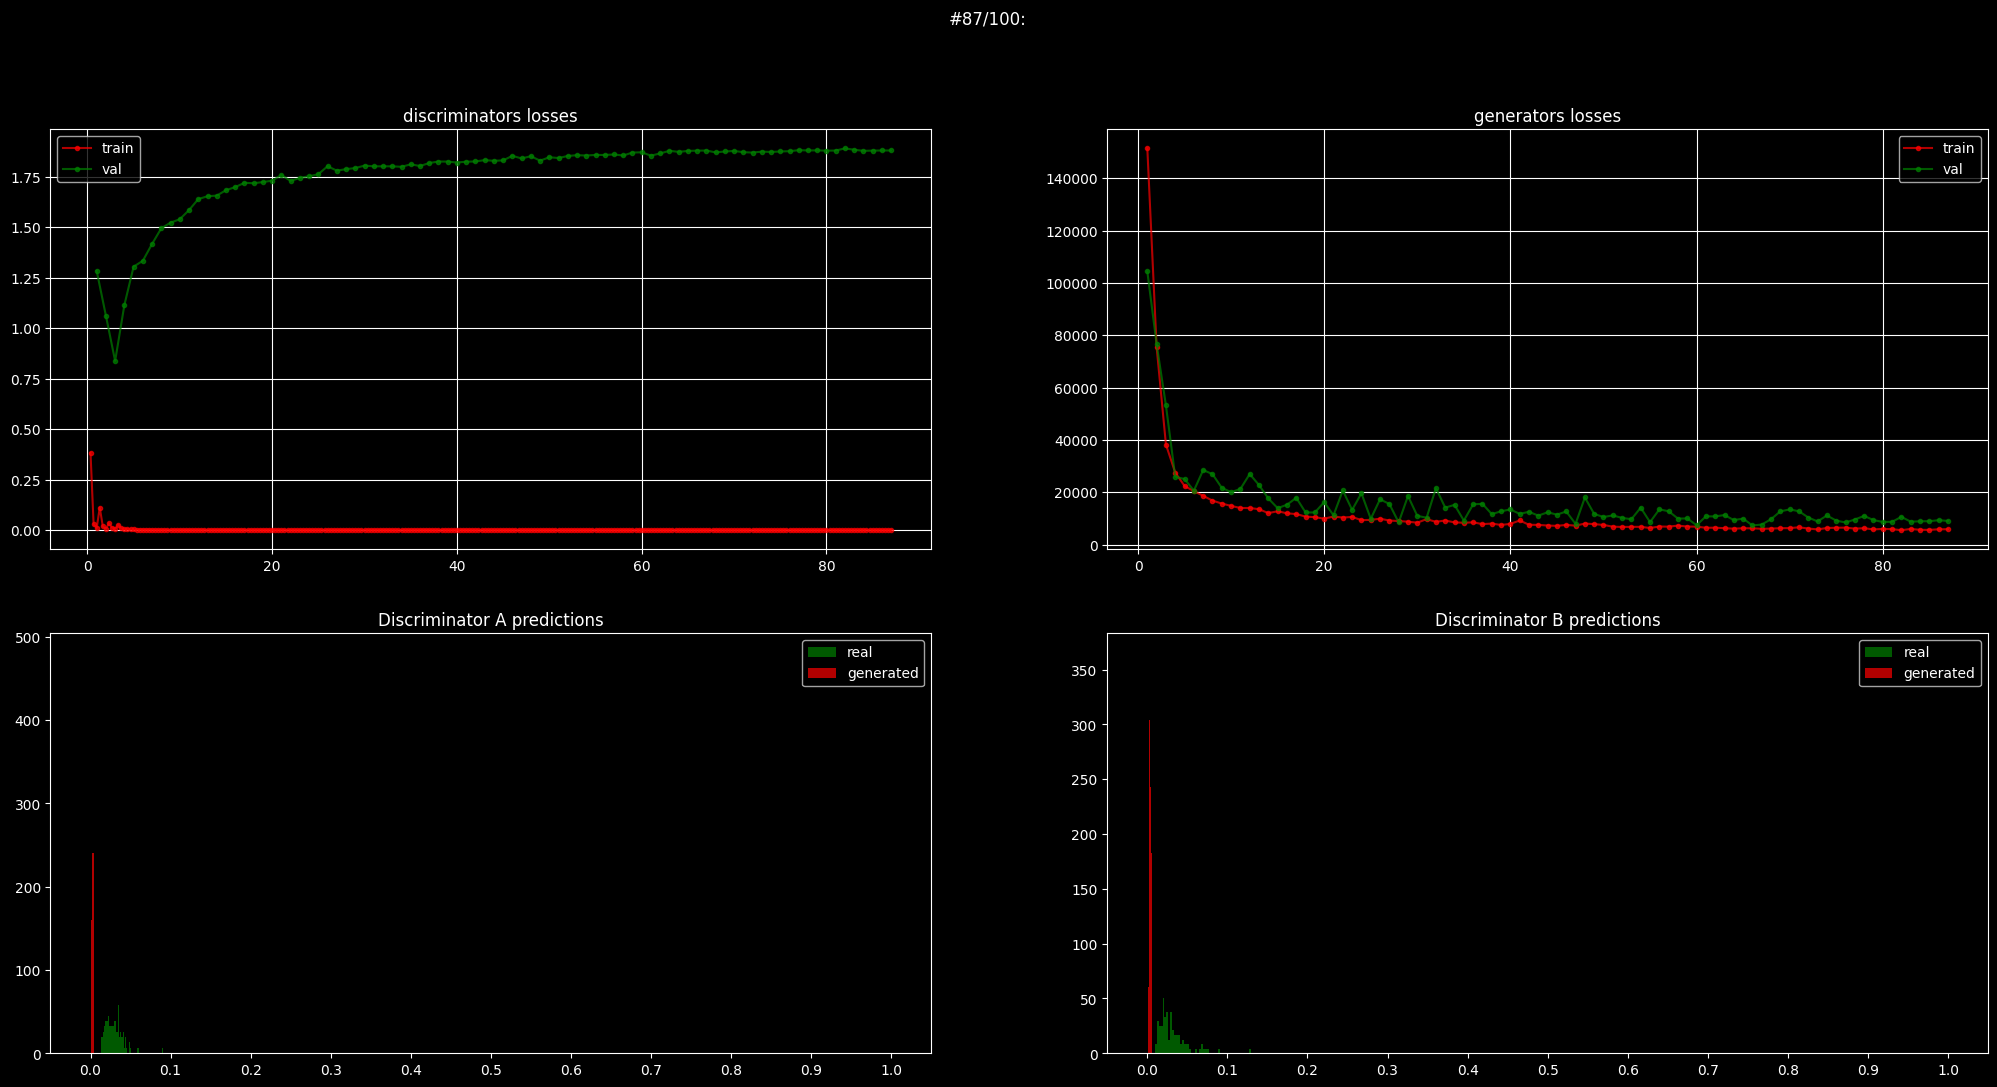

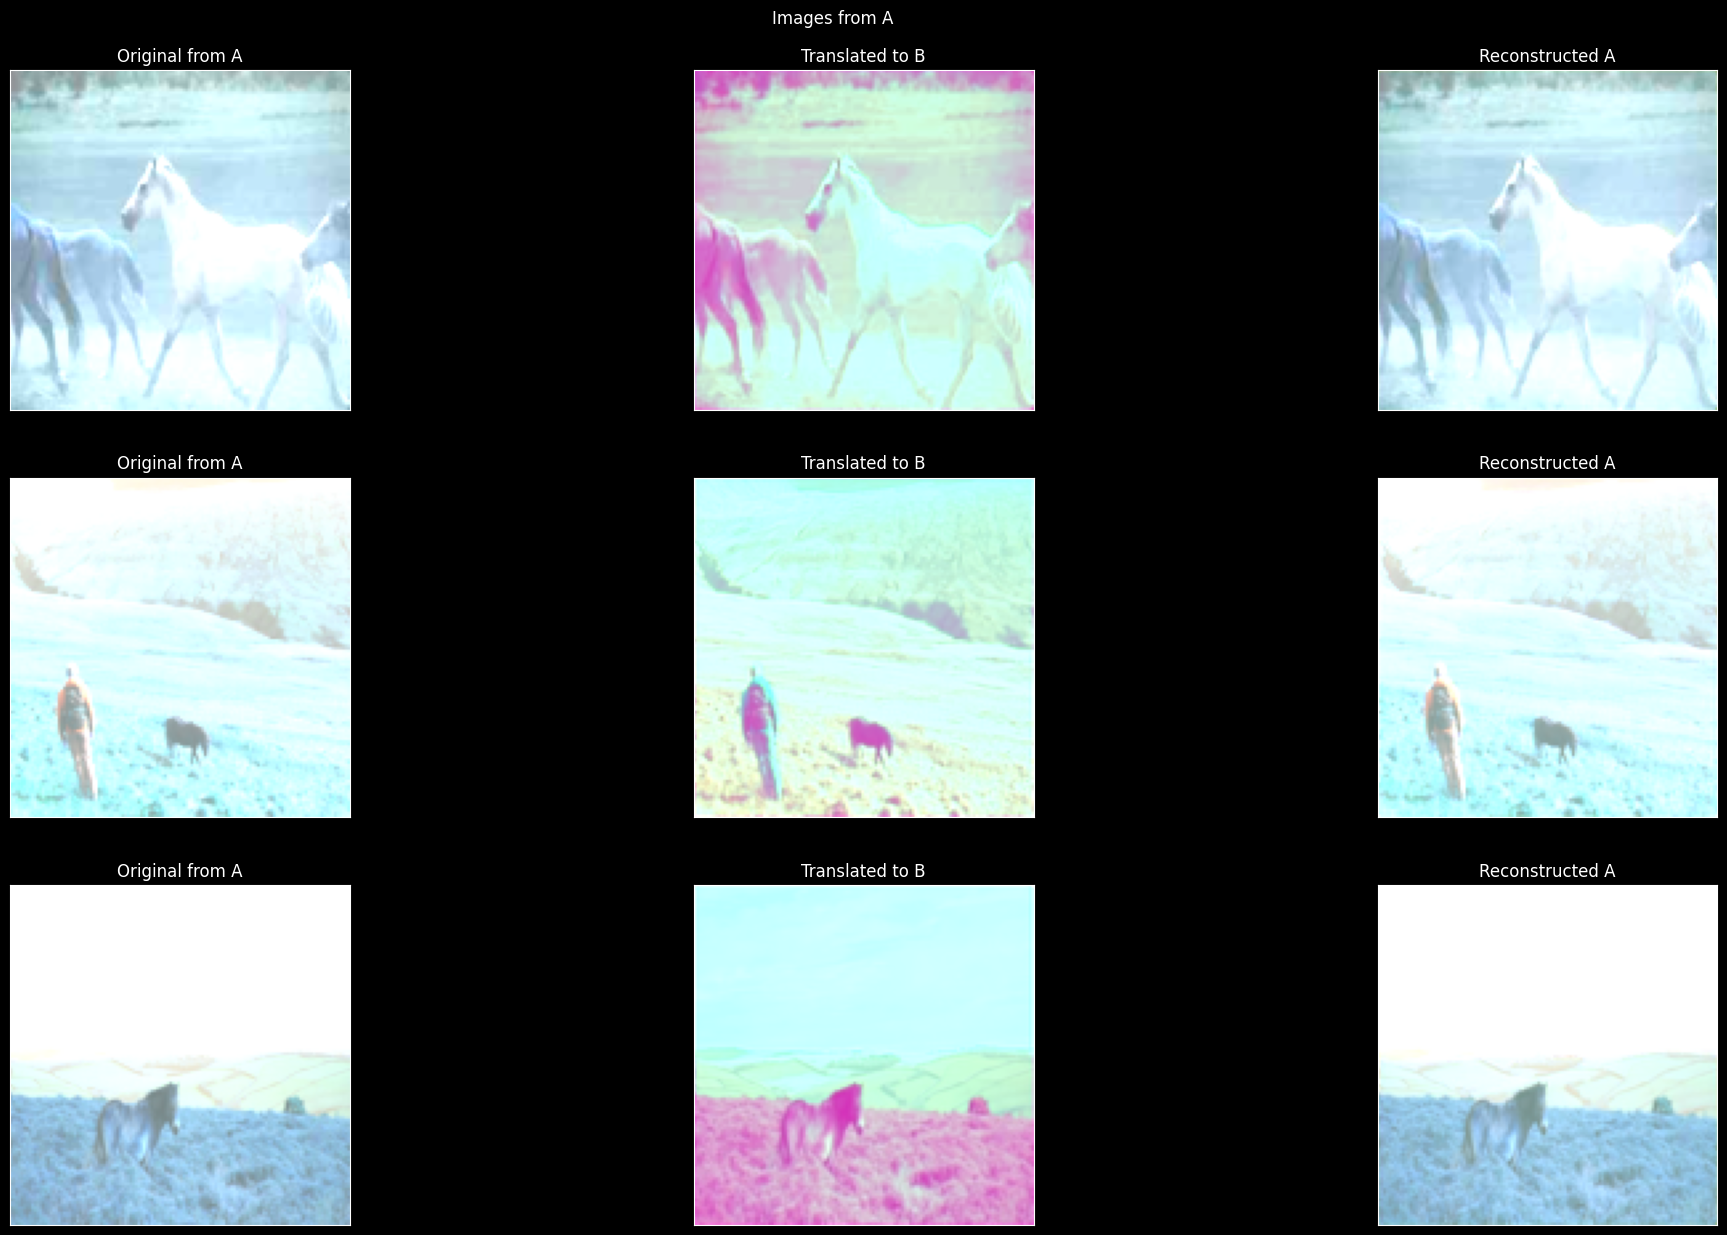

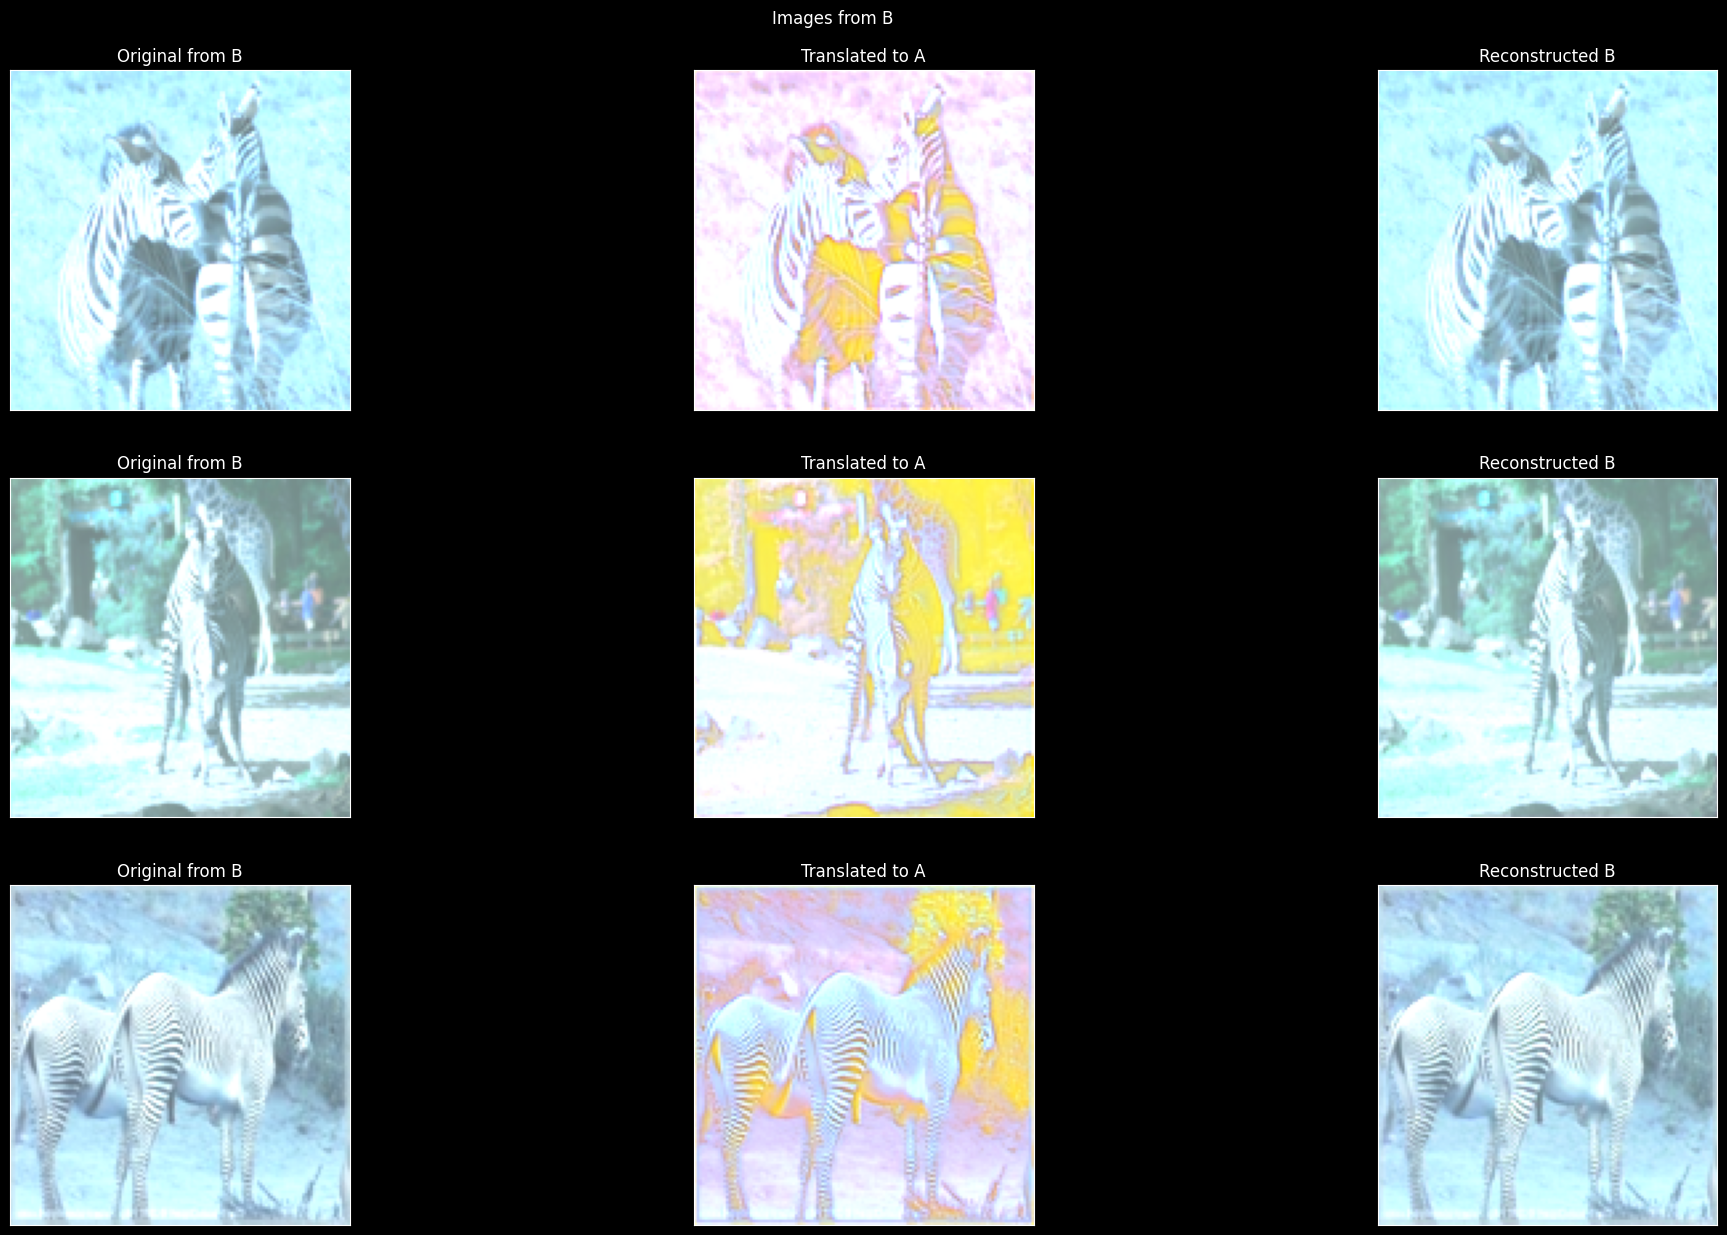

#88/100:
train discriminators (3 times)


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

train generators (1 times)


  0%|          | 0/21 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [120]:
%%time
model, optimizer_d, optimizer_g, plots = learning_loop(
    model = model,
    optimizer_g = optimizer_g,
    g_iters_per_epoch = 1,
    optimizer_d = optimizer_d,
    d_iters_per_epoch = 3,
    train_loader_a = dataloaders.train_a,
    train_loader_b = dataloaders.train_b,
    val_loader_a = dataloaders.test_a,
    val_loader_b = dataloaders.test_b,
    criterion_d = criterion_d,
    criterion_g = criterion_g,
    scheduler_g = scheduler_g,
    scheduler_d = scheduler_d,
    de_norm_a = de_normalize_a,
    de_norm_b = de_normalize_b,
    epochs = 100,
    min_lr = 1e-6,
    val_every = 1,
    draw_every = 1,
    chkp_folder = "./chkp",
    model_name = "cycle_gan",
    images_per_validation=3,
    plots=None,
    starting_epoch=0,
)

In [ ]:
img_a = ds.test_a[1].to(device).unsqueeze(0)

plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(121)
plt.imshow(de_normalize_a(img_a[0]))

plt.subplot(122)
plt.imshow(de_normalize_b(model.generators["a_to_b"](img_a)[0]))

plt.show()

In [ ]:
img_a = ds.test_a[5].to(device).unsqueeze(0)

plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(121)
plt.imshow(de_normalize_a(img_a[0]))

plt.subplot(122)
plt.imshow(de_normalize_b(model.generators["a_to_b"](img_a)[0]))

plt.show()

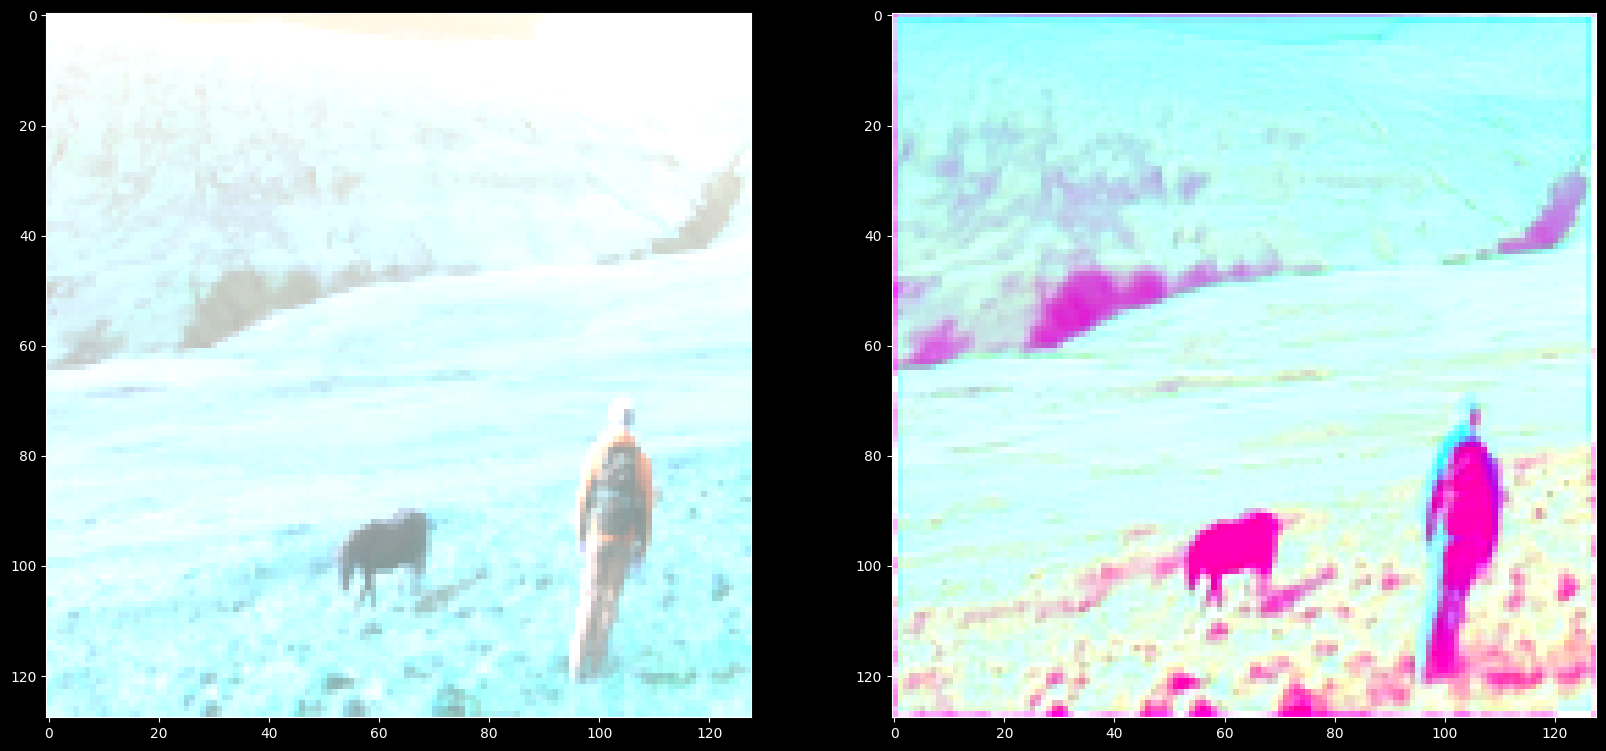

In [122]:
img_ind = 1
img_a = ds.test_a[img_ind].to(device).unsqueeze(0)
fake_b = model.generator_a_b(img_a)[0]

plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(121)
plt.imshow(de_normalize_a(img_a[0]))

plt.subplot(122)
plt.imshow(de_normalize_b(fake_b))

plt.show()

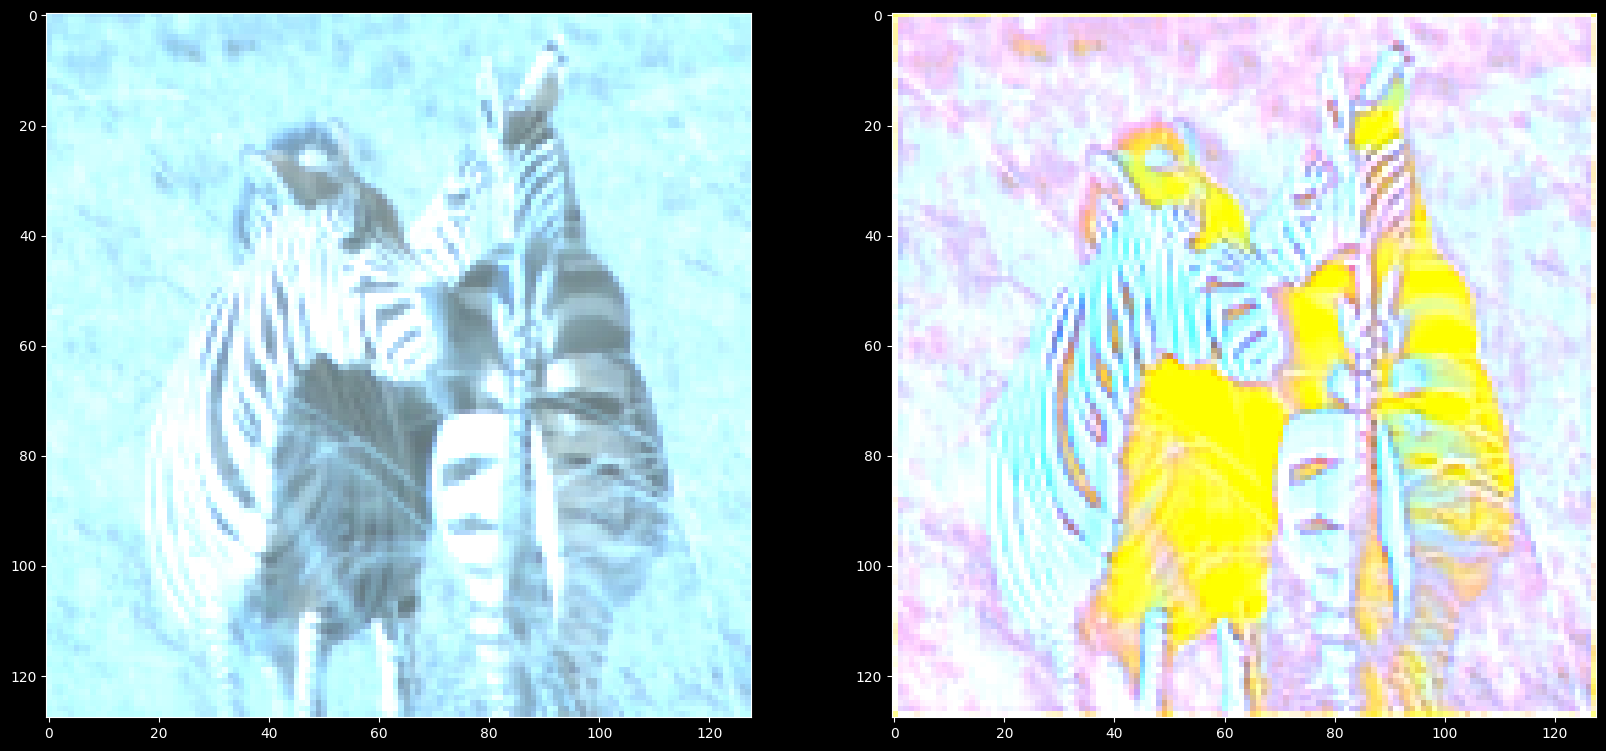

In [123]:
img_ind = 0
img_b = ds.test_b[img_ind].to(device).unsqueeze(0)
fake_a = model.generator_b_a(img_b)[0]

plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(121)
plt.imshow(de_normalize_b(img_b[0]))

plt.subplot(122)
plt.imshow(de_normalize_a(fake_a))

plt.show()

# 5. Свои данные (___3 балла + бонусы___)

В этой части нужно сделать следующее:

* Собрать свой один или пару небольших датасетов (хотя бы 100 примеров, но чем больше тем лучше у вас будет качество финальной модели) - формально ограничений нет, но давайте без чего-то неадекватного или за рамками
* Обучить модель CycleGAN между вашим датасетом и каким-то ещё (либо так же вашим, либо любым существующим - полностью на вашу фантазию)
* Для сдачи задания - требуется
    * приложить ссылку на заархивированный датасет, на котором вы обучались
    * в ноутбуке сделать наглядную визуализацию данных из A и B (желательно с текстовым описанием вашей задумки)
    * в ноутбуке иметь код обучения вашей модели
    * в ноутбуке иметь визуальные результаты работы вашей модели (A в B и B в A - хотя бы по 5 примеров на каждый)
* __Задание предполагает возможность получения дополнительных баллов сверх стоимости домашки за интересные и качественные датасеты, а так же модели высокого качества__

___Удачи!___